In [201]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
%matplotlib inline

import glob
import os
import random

In [202]:
df = pd.DataFrame()

male = [0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 14, 17, 21, 23, 24, 27, 28, 29, 30, 33, 36, 37, 41, 42, 43, 44, 46, 48, 50, 51, 53, 56, 58, 59, 60, 61]
female = [4, 5, 8, 15, 16, 18, 19, 20, 22, 25, 26, 31, 32, 34, 35, 38, 39, 40, 45, 47, 49, 52, 54, 55, 57, 62]

for csv in glob.glob('./raw_subset/*.csv'):
    id = os.path.splitext(os.path.basename(csv))[0]
    new = pd.DataFrame(pd.read_csv(csv, header=None, skiprows=[0])).iloc[:, :-2]
    new['id'] = id
    # Note: Previously the line below had "int(id) + 1" to check against, this seemed incorrect so I have changed it
    # It is not clear where the gender information has come from anyway
    new['gender'] = 'm' if int(id) - 1 in male else 'f'
    df = pd.concat([df, new])

columns = list(pd.read_csv('./raw_subset/1.csv', header=0).columns[:-2]) + ['id', 'gender']
df.columns = columns
df.set_index(['id', 'index'], inplace=True)

In [203]:
df

time   L_x  L_y  L_z   C_x  C_y  C_z  F_x  F_y  F_z  ...  \
id index                                                          ...   
1  1        0.000 -15.6  0.0 -2.1 -19.8  2.5 -4.2  1.0 -0.3  0.0  ...   
   2        0.068 -15.3  0.9 -3.8 -19.8  1.8 -4.2  1.0 -0.2  0.0  ...   
   3        0.100 -15.5  1.9 -4.9 -19.9  1.7 -4.2  1.0  0.0 -0.2  ...   
   4        0.168 -15.5  2.2 -5.3 -19.9  1.7 -4.2  1.0  0.0 -0.2  ...   
   5        0.200 -15.5  2.3 -5.4 -19.9  1.7 -4.2  1.0  0.0 -0.2  ...   
...           ...   ...  ...  ...   ...  ...  ...  ...  ...  ...  ...   
9  3349   121.690  -9.3  1.6 -4.5 -14.5  1.7 -2.6  1.0  0.1 -0.1  ...   
   3350   121.720  -9.3  1.6 -4.5 -14.5  1.7 -2.6  1.0  0.1 -0.1  ...   
   3351   121.790  -9.3  1.6 -4.5 -14.5  1.7 -2.6  1.0  0.1 -0.1  ...   
   3352   121.830  -9.3  1.7 -3.7 -14.5  1.7 -2.6  1.0  0.1 -0.1  ...   
   3353   121.860  -9.3  1.7 -3.7 -14.5  1.7 -2.6  1.0  0.1 -0.1  ...   

          circle_3d_normal_y  circle_3d_normal_z  circle_3d_radius     theta  \
id index                                                                       
1  1                0.152262           -0.986598      1.659080e+00  1.723653   
   2                0.404107           -0.914686      1.660638e+00  1.986799   
   3                0.422262           -0.904448      1.662946e+00  2.006735   
   4                0.449055           -0.886505      1.669928e+00  2.036504   
   5                0.466126           -0.874104      1.661172e+00  2.055703   
...                      ...                 ...               ...       ...   
9  3349             0.000000            0.000000      0.000000e+00  0.000000   
   3350             0.000000            0.000000      0.000000e+00  0.000000   
   3351             0.000000            0.000000      0.000000e+00  0.000000   
   3352            -0.199438           -0.968304      3.340000e-08  1.370012   
   3353            -0.199438           -0.968304      3.330000e-08  1.370012   

               phi  projected_sphere_center_x  projected_sphere_center_y  \
id index                                                                   
1  1     -1.511417                 361.230800                 103.117509   
   2     -1.578306                 361.230800                 103.117509   
   3     -1.637669                 361.230800                 103.117509   
   4     -1.696043                 361.230800                 103.117509   
   5     -1.725856                 361.230800                 103.117509   
...            ...                        ...                        ...   
9  3349   0.000000                 416.284114                 367.699363   
   3350   0.000000                 416.284114                 367.699363   
   3351   0.000000                 416.284114                 367.699363   
   3352  -1.724863                 416.284114                 367.699363   
   3353  -1.724863                 416.284114                 367.699363   

          projected_sphere_axis_a  projected_sphere_axis_b  gender  
id index                                                            
1  1                   591.110093               591.110093       m  
   2                   591.110093               591.110093       m  
   3                   591.110093               591.110093       m  
   4                   591.110093               591.110093       m  
   5                   591.110093               591.110093       m  
...                           ...                      ...     ...  
9  3349               1280.590074              1280.590074       f  
   3350               1280.590074              1280.590074       f  
   3351               1280.590074              1280.590074       f  
   3352               1280.590074              1280.590074       f  
   3353               1280.590074              1280.590074       f  

[242197 rows x 42 columns]

Simple exploratory data analysis.

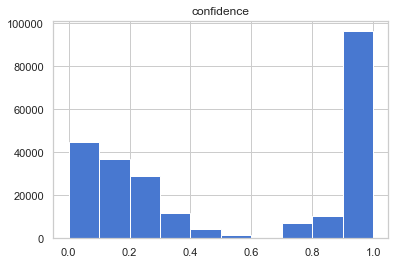

In [204]:
df.hist(column='confidence');

We want to filter the low confidence eye measurements from the data as these are generally quite inaccurate (in correlation to the adjacent more confident measurements). There is also a clear distinction in the histogram between high-confidence (>0.6) measurements and low-confidence ones.

Edit: now that we are also using phi, which is the longitudinal eye angle, will also threshold on model_confidence though I suspect there is heavy overlap

We also take only relevant columns for analysis. Excluding the preliminary pupil parameters for instance.

Edit: now including phi and the camera angle

In [205]:
relevant = ['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'confidence', 'model_confidence', 'gender', 'phi', 'F_x', 'F_y', 'F_z']
df = df[relevant]

In [206]:
# More data cleaning

# Drop repeated consecutive times (drop first)
df = df.loc[df['time'].shift() != df['time']]

# Drop row at time 0.000 (index 1) as these are not accurate
df = df.loc[df['time'] != 0.000]

# Keep only confident eye tracking coords for eye path analysis
df_eye = df[(df['confidence'] > 0.6) & (df["model_confidence"] > 0.6)]

# Remove some outlier PoG eye measurments (some are outside of the room coordinates)
df_eye = df_eye[(df_eye['L_x'] >= -23.9) & (df_eye['L_x'] <= -9)]
df_eye = df_eye[(df_eye['L_y'] >= 0) & (df_eye['L_y'] <= 3.7)]
df_eye = df_eye[(df_eye['L_z'] >= -9.7) & (df_eye['L_z'] <= 0.4)]

df.drop(['L_x', 'L_y', 'L_z', 'phi', 'model_confidence'], axis=1, inplace=True)
df_eye.drop(['time', 'C_x', 'C_y', 'C_z', 'confidence', 'gender', 'F_x', 'F_y', 'F_z', 'model_confidence'], axis=1, inplace=True)
# note: happy to drop model_confidence altogether now this thresholding is done


In [207]:
# Merge back in filtered eye data
df = pd.merge(df.reset_index(), df_eye.reset_index(), how='left', on=['id', 'index']).set_index(keys=['id', 'index'])

In [208]:
# to correlate the full camera position data with the interrupted (from earlier cleaning) PoG data we use the nearest index matched by time
def get_nearest_time_index(time, L_times, L_indices):
    return np.array(L_indices)[np.argmin(np.abs(np.array(L_times) - time))]

new_L = df[["L_x", "L_y", "L_z", "phi"]].copy()
for id in df.index.levels[0]:
    not_na_times = df.loc[id].dropna()["time"]
    not_na_indices = df.loc[id].dropna().index
    na_indices = df.loc[id][pd.isna(df.loc[id]["L_x"])].index
    for index in na_indices:
        new_index = get_nearest_time_index(df.loc[(id, index)]["time"],not_na_times,not_na_indices)
        new_L.loc[(id, index)] = df.loc[(id, new_index)][["L_x", "L_y", "L_z", "phi"]]

df[["L_x", "L_y", "L_z", "phi"]] = new_L
    

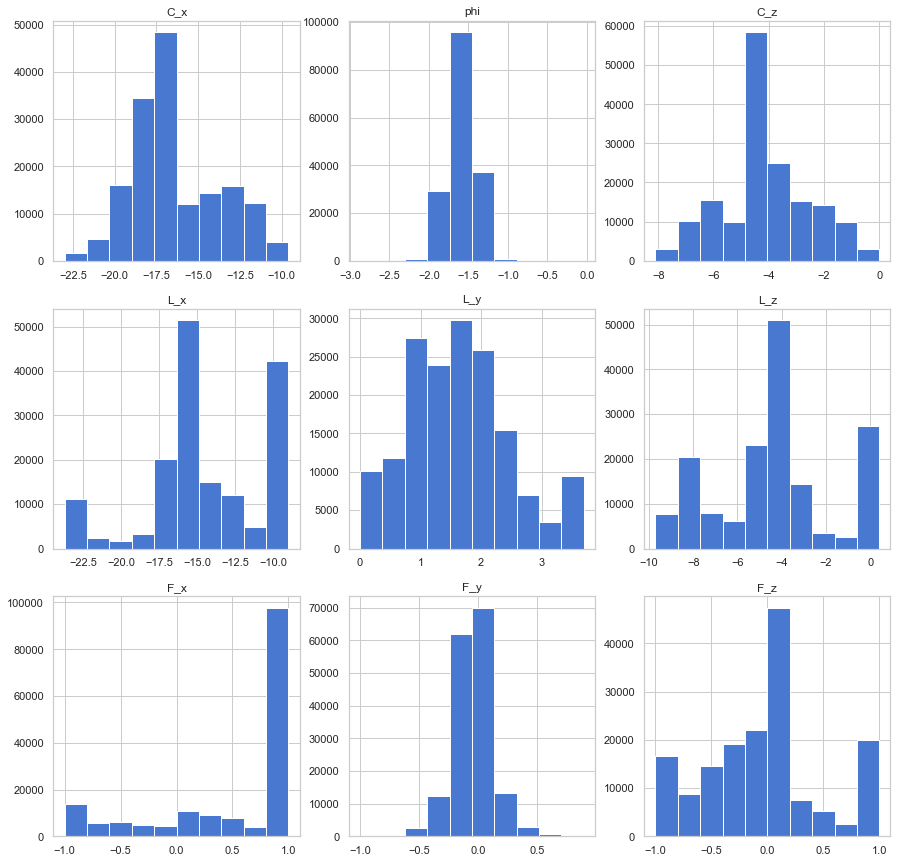

In [234]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i, col in enumerate(['C_x', 'phi', 'C_z', 'L_x', 'L_y', 'L_z', 'F_x', 'F_y', 'F_z']):
  axs[i//3, i%3].hist(df[col])
  axs[i//3, i%3].set_title(col)

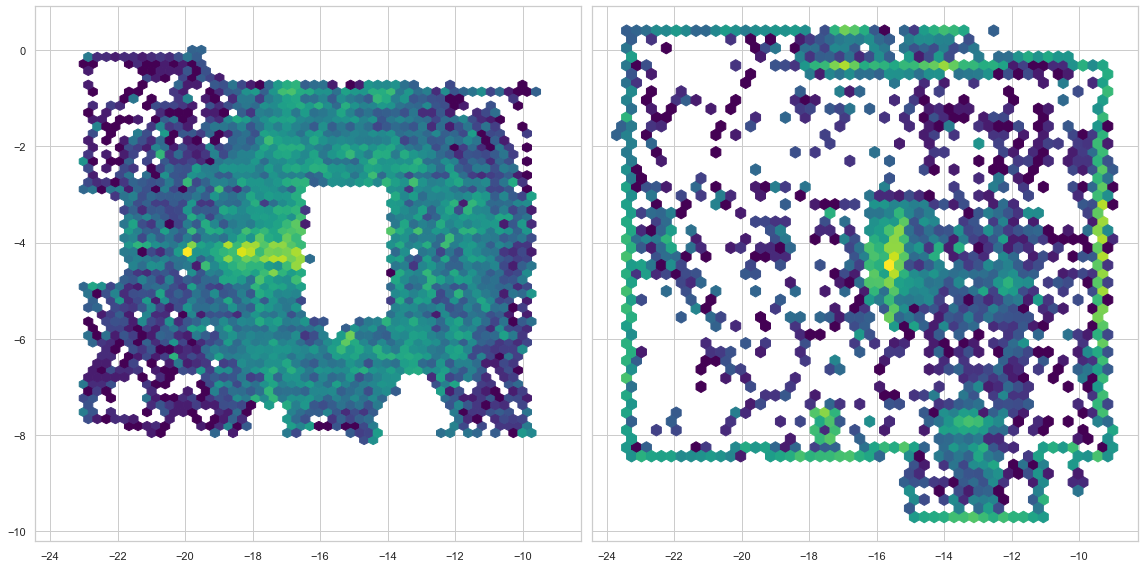

In [210]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)

pc = ax[0].hexbin(df['C_x'], df['C_z'], cmap='viridis', mincnt=1, gridsize=50, bins='log')
pc = ax[1].hexbin(df['L_x'], df['L_z'], cmap='viridis', mincnt=1, gridsize=50, bins='log')
fig.tight_layout()

Clear to see that the predominant area for users to stand in is central around the main attraction of the museum, in particular the main information panel.

Again this main information panel is very apparent in the PoG data, and the other areas of interest, the museum exhibits are clearly discernable as high density patches. 
And the other which users focus on is the walls.

In [211]:
# Camera Y position should be fixed (only variance comes from jitter and is not relevant for analysis)
df.drop('C_y', axis=1, inplace=True)

## Metrics

Here we generate trajectory metrics (based on the camera position) which can be used in analysis or used for further techniques such as path segmentation.
Eye tracking metrics will be performed later and in relation to segmented paths.

In [212]:
import math
def distance_3d(x1, y1, z1, x2, y2, z2):
  return math.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)

def distance_2d(x1, z1, x2, z2):
  return math.sqrt((x2-x1)**2 + (z2-z1)**2)

def bearing_2d(x1, z1, x2, z2):
  return abs(math.atan2(x2 - x1, z2 - z1))

In [213]:
C_metrics = {}

for id in df.reset_index().id.unique():
  user_df = df.loc[id]
  pt = user_df.iloc[0, 0]
  px, pz = user_df.iloc[0, 1:3]
  pbearing = 0

  distances = []
  velocities = []
  times = []
  turning_angles = []
  for j in range(1, len(user_df.iloc[1:, 1:3]) + 1):
    x, z = user_df.iloc[j, 1:3]
    t = user_df.iloc[j, 0]
    d = distance_2d(px, pz, x, z)
    distances.append(d)
    velocities.append(d / (t - pt))
    times.append(t)

    bearing = bearing_2d(x, z, px, pz)
    turning_angles.append(abs(bearing - pbearing))

    px, pz, pt = x, z, t
    pbearing = bearing

  C_metrics[id] = {'v': velocities, 't': times, 'step_d': distances, 'heading_change' : turning_angles}

In [214]:
random.seed(747)
sample = random.sample(C_metrics.keys(), 10)

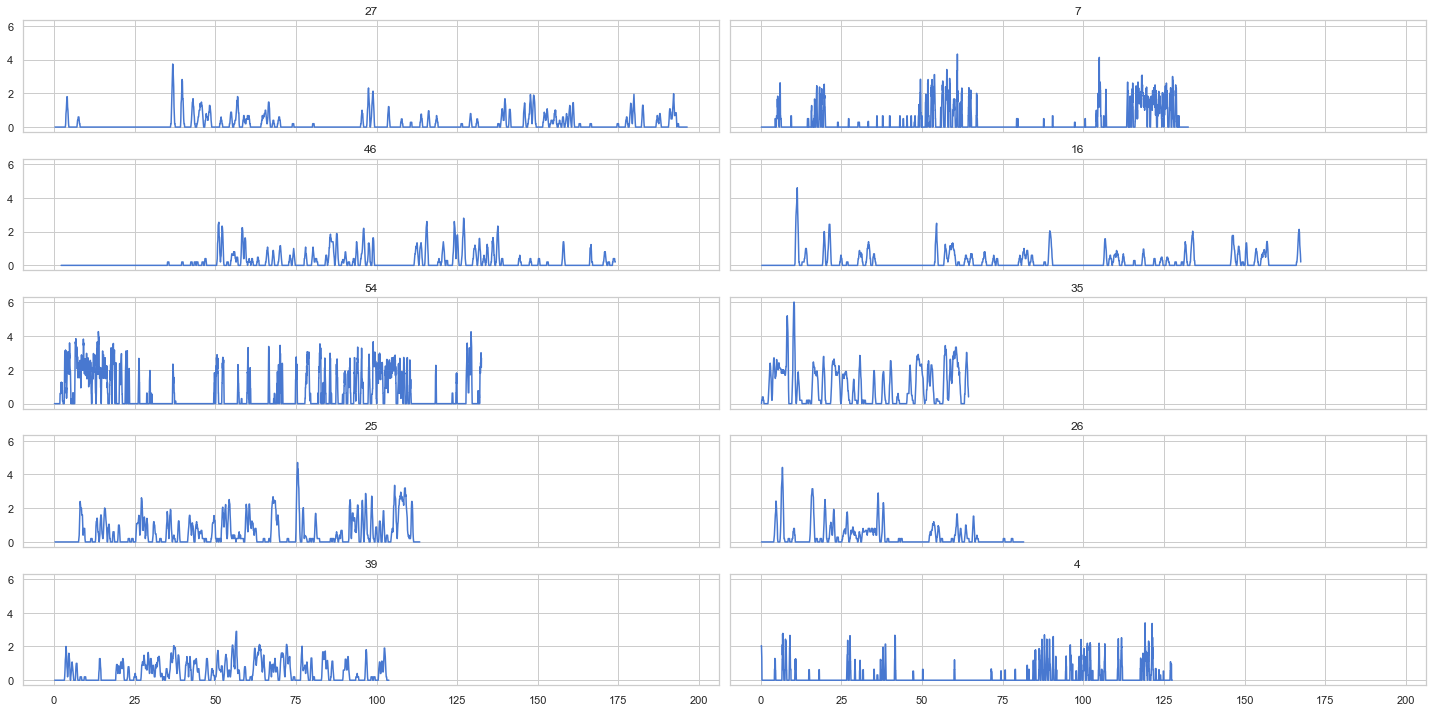

In [215]:
# Plot smoothed moving average speeds
window = 5

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

for k in C_metrics.keys():
    C_metrics[k]['ma_v'] = moving_average(C_metrics[k]['v'], window)

fig, ax = plt.subplots(5, 2, figsize=(20,10), sharey=True, sharex=True)

for i, k in enumerate(sample):
    ax[i//ax.shape[1], i%ax.shape[1]].plot(C_metrics[k]['t'][:-window + 1], C_metrics[k]['ma_v'])
    ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)

fig.tight_layout()

Path segmentation approaches

- Basic change point analysis of users staying still for n seconds
- PELT algorithm
    - applicable due to regular time sampling and the aim of change point detection
    - DOI 10.1186/s40462-016-0086-5
    - and https://arxiv.org/pdf/1101.1438.pdf

In [216]:
# Create path segmentations where users stay still for n seconds to look at something
# Type of simple change point analysis

# New paths start when movement begins again

# Number of seconds to break path on no movement
path_break = 1

for k, v in C_metrics.items():
    path_breaks = []
    last_motion = 0 # time of last motion
    waiting_for_next_motion = True
    for i, vel in enumerate(v['v']):
        if vel != 0:
            last_motion = v['t'][i]
            if waiting_for_next_motion:
                path_breaks.append(i)
                waiting_for_next_motion = False
        elif v['t'][i] - last_motion > path_break:
            waiting_for_next_motion = True
    path_breaks.append(len(v['v']))
    C_metrics[k]['path_breaks'] = path_breaks

print(C_metrics['3']['path_breaks'])

[1, 198, 260, 386, 456, 896, 967, 1069, 1285, 1645, 1742, 1876, 1979, 2101, 2240, 2406, 2608, 2698, 2711]


In [217]:
# More sophisticated PELT changepoint detection of paths

# PELT Path Segmentation Algorithm
# Implementation from https://github.com/nicodesh/pelt-algorithm/blob/master/pelt.py
# https://arxiv.org/pdf/1101.1438.pdf

def pelt(data, **kwargs):
    # Pre-processing
    df = pd.DataFrame(data)
    df['squared'] = np.square(df[0])
    df['cumsum'] = np.cumsum(df[0], axis=0)
    df['cumsumsquared'] = np.cumsum(df['squared'], axis=0)
    df['diviseur'] = [x for x in range(1,len(df)+1)]
    df['mean'] = df['cumsum'] / df['diviseur']
    df['meansquared'] = np.square(df['mean'])
    df = df.append({
        0:0,
        'cumsum':0,
        'cumsumsquared':0,
        'diviseur':0,
        'mean':0,
        'meansquared':0,
        'squared':0}, ignore_index=True)
    
    # Penalty
    if 'penalty' in kwargs:
        B = kwargs['penalty']
    else:
        B = 2 * np.log(len(data))
    
    # Initilization
    Q = [-B] # Actual cost
    CP = [-1] # Last segment position
    T = [x for x in range(0,len(data))] # Authorized positions

    # Parse the data
    for pos in range(0,len(data)):
        
        costs = []
        min_cost_val_temp = float("inf")
        min_cost_pos_temp = -1
        
        # Parse all the Yi:pos that are still available
        for i in T:
            if i > pos:
                break

            # Square sum minus N times the square mean
            sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[i-1]
            n = pos - i + 1
            ms = (data[i:pos+1].mean())**2
            C = sos - (n*ms)

            # Cost test
            temp_cost = Q[i] + C + B
            if min_cost_val_temp > temp_cost:
                min_cost_val_temp = temp_cost
                min_cost_val_pos = i

        # Push the smallest cost
        Q.append(min_cost_val_temp)

        # Push the position
        CP.append(min_cost_val_pos)
        
        # Prunning
        for i in T:
            if i >= pos:
                break
            
            iplusone = i+1
            # Square sum minus N times the square mean
            sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[iplusone-1]
            n = pos - iplusone + 1
            ms = (data[iplusone:pos+1].mean())**2
            C = sos - (n*ms)
                
            if (Q[i] + C > Q[pos]):
                T.remove(i)
                
    return CP

def backtracking(CP):
    """ Apply backtracking to a CP vector from OP algorithm. Returns a "segments" vector.
    Args:
     CP: array-like 1 dimension.
    """

    # Data length
    n = len(CP)-1

    # Initialization
    segments = []
    changepoint = CP[n]

    # While the changepoint doesn't return the first point
    while changepoint > 0:

        segments.append(changepoint-1)
        changepoint = CP[changepoint]

    # The new vector was built with .append(), but since we parse from the end to the beginning,
    # We need to reverse it.
    segments.reverse()
    segments.append(n)
    return segments

# Commented as get more intuitive results with non-pelt
# for k, v in C_metrics.items():
#     cp = pelt(np.array(v['v']))
#     pb = backtracking(cp)
#     pb.insert(0, C_metrics[k]['path_breaks'][0]) # Add the first movement as start of trajectories
#     C_metrics[k]['path_breaks'] = sorted(list(dict.fromkeys(pb)))

Visualize path segments

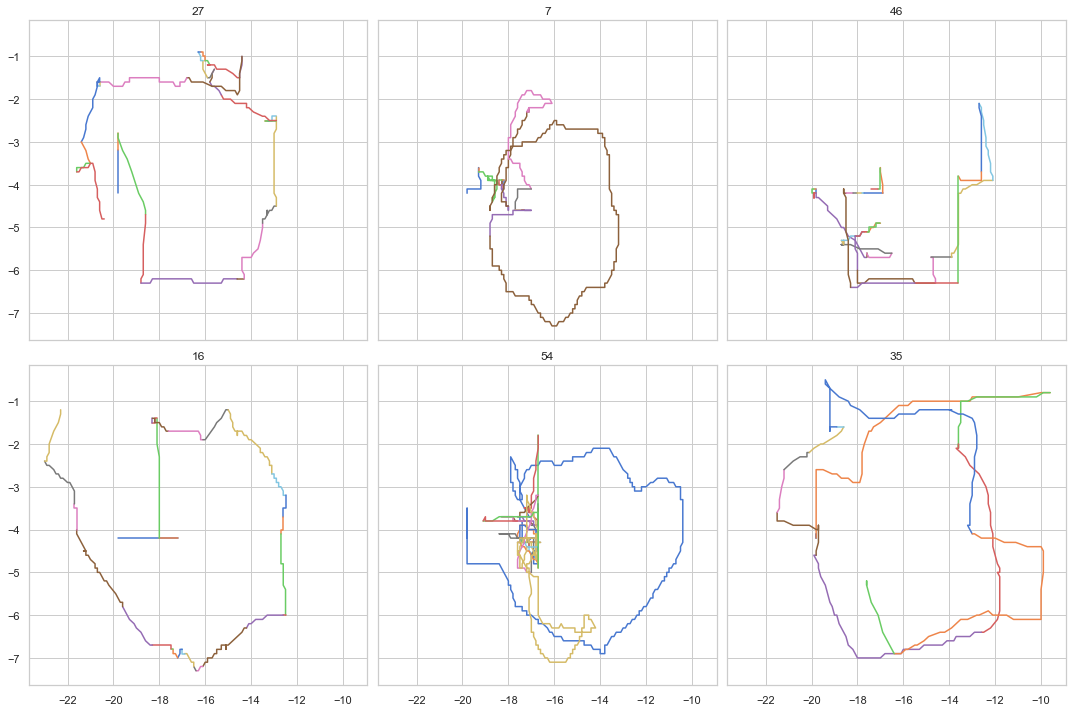

In [218]:
# fig, ax = plt.subplots(5, 2, figsize=(20,10), sharey=True, sharex=True)
# for i, k in enumerate(sample):
#     ex = C_metrics[k]
#     for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
#         path_end -= 1
#         if path_end > len(ex['ma_v']):
#             path_end -= window + 1
#         ax[i//ax.shape[1], i%ax.shape[1]].plot(ex['t'][path_start:path_end], ex['ma_v'][path_start:path_end])
#         ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)
# fig.tight_layout()

fig, ax = plt.subplots(2, 3, figsize=(15,10), sharey=True, sharex=True)

for i, k in enumerate(sample[:ax.size]):
    ex = C_metrics[k]
    user_df = df.loc[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end += 1
        
        ax[i//ax.shape[1], i%ax.shape[1]].plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end])
        ax[i//ax.shape[1], i%ax.shape[1]].set_title(k)
fig.tight_layout()

Here we create metrics for the path segments individually

- Straightness, velocity, path length, total displacement

In [219]:
# Straigtness calculated as D/L as per https://doi.org/10.1016/j.jtbi.2004.03.016
# Path velocities also calculated
# User rdp to rediscretize to a defined steplength to calculate sinuosity

for k, v in C_metrics.items():
    user_df = df.loc[k]
    straightness = []
    velocities = []
    lengths = []
    displacements = []
    times = []
    sinuosities = []

    for path_start, path_end in zip(v['path_breaks'], v['path_breaks'][1:]):
        s, e = user_df.iloc[path_start], user_df.iloc[path_end - 1]
        D = distance_2d(s['C_x'], s['C_z'], e['C_x'], e['C_z'])
        L = 0
        for i in range(path_start, path_end):
            # Note: line below was found multiplying by 30, but then all results were way too small
            # Could not think of a reason why it was there and results seem to make more sense now it is removed
            L += v['step_d'][i]
        if (L == 0):
            straightness.append(1)
        else:
            if L < D:
                print(D, L)
            straightness.append(D/L)
        velocities.append(np.mean(v['v'][path_start:path_end]))

        # Exclude end 2+ seconds of stillness from the average velocity
        # Only for basic non-pelt segmentation
        # velocities.append(np.mean(v['v'][path_start:path_end][:np.max(np.nonzero(v['v'][path_start:path_end])) + 1]))
        
        lengths.append(L)
        displacements.append(D)
        times.append(e['time'] - s['time'])

        # Sinuosities over reparameterized coordinates
        # turning_angles = []
        # pbearing = 0
        # px, pz = s['C_x'], s['C_z']
        # for (x, z) in rdp(user_df.iloc[path_start+1:path_end-1][['C_x', 'C_z']].to_numpy(), 0.001):
        #     bearing = bearing_2d(x, z, px, pz)
        #     turning_angles.append(bearing - pbearing)
        #     px, pz, pbearing = x, z, bearing
        # # sinuosities.append(1.18 * np.std(turning_angles) / math.sqrt(0.1))
        # sinuosities.append(np.mean(np.cos(turning_angles)))


    C_metrics[k]['path_straightness'] = straightness
    C_metrics[k]['path_velocities'] = velocities
    C_metrics[k]['path_lengths'] = lengths
    C_metrics[k]['path_displacements'] = displacements
    C_metrics[k]['path_times'] = times
    # C_metrics[k]['path_sinuosities'] = sinuosities


Visualize path straightness as a metric

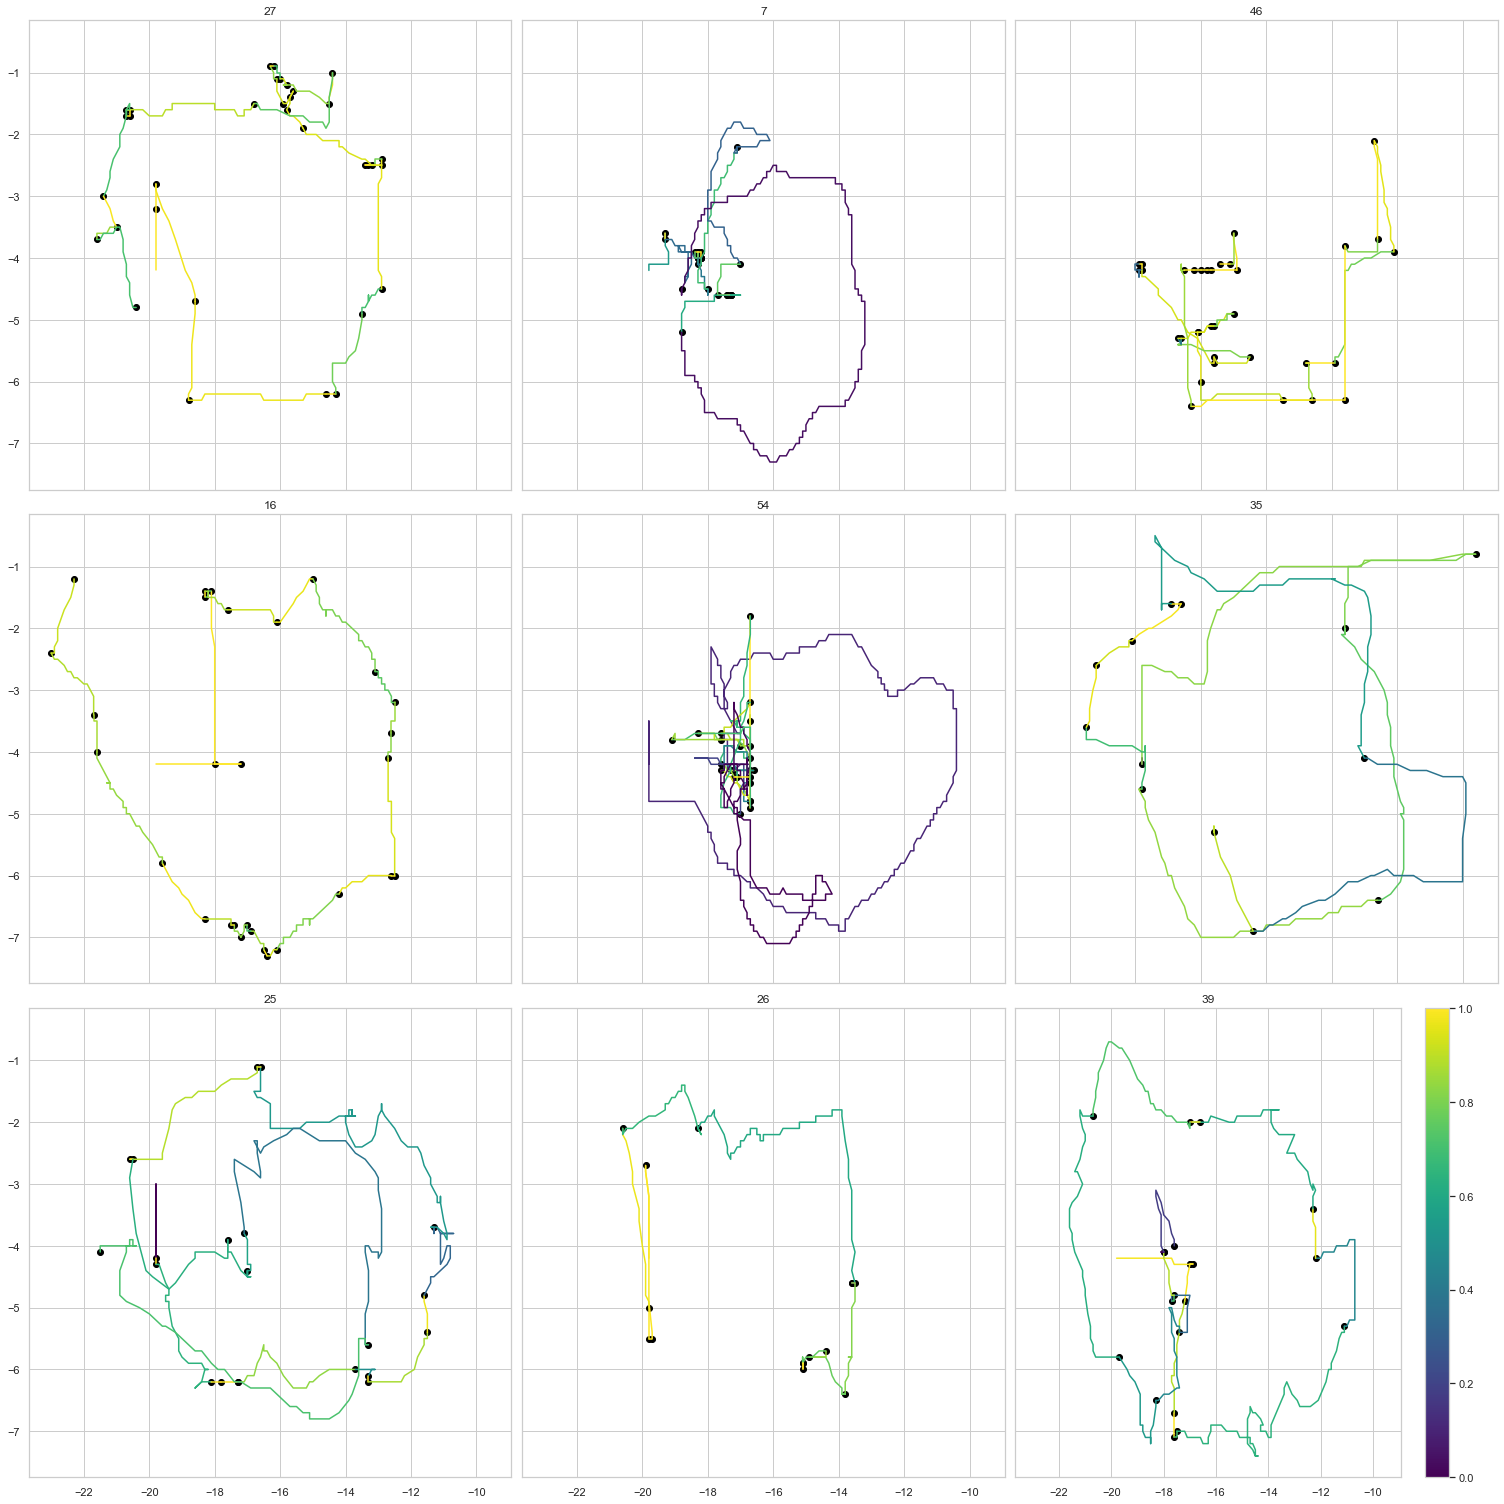

In [220]:
fig, ax = plt.subplots(3, 3, figsize=(21, 21), sharey=True, sharex=True)

norm = plt.Normalize(0, 1)
cm_norm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

for i, k in enumerate(sample[:ax.size]):
    ex = C_metrics[k]
    user_df = df.loc[k]
    for path_start, path_end in zip(ex['path_breaks'], ex['path_breaks'][1:]):
        path_end += 1
        ax[i//ax.shape[1], i % ax.shape[1]
           ].plot(user_df['C_x'].iloc[path_start:path_end], user_df['C_z'].iloc[path_start:path_end], color=cm_norm.to_rgba(ex['path_straightness'][ex['path_breaks'].index(path_start)]))
        ax[i//ax.shape[1], i % ax.shape[1]].set_title(k)
        # Note: I have added the below scatter points to make it clear where a path segment ends and the next one starts
        ax[i//ax.shape[1], i % ax.shape[1]
           ].scatter(user_df['C_x'].iloc[path_end-1], user_df['C_z'].iloc[path_end-1], color="black")

fig.tight_layout()
fig.colorbar(cm_norm)


The below illustrates how different users have different movement profiles.

For example user 19 moves in typically straighter paths, noticeable in comparison to user 39.

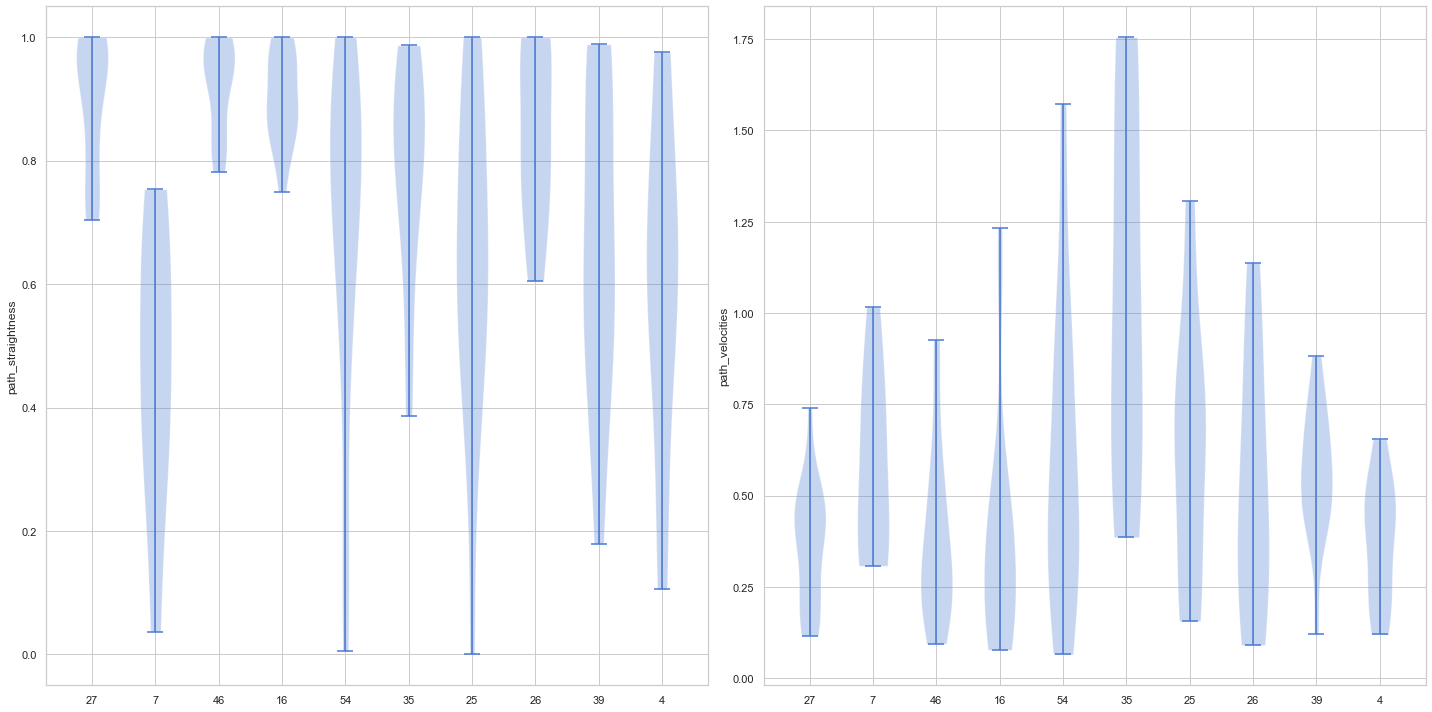

In [222]:
# Violin Plots of straightness by user, illustrate different exploration patterns per person
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

for i, cat in enumerate(['path_straightness', 'path_velocities']):
    # Note: I have added a filter on path length to remove small paths which aren't representative of actual behaviour
    selected = [[C_metrics[j][cat][k] for k in range(len(C_metrics[j][cat])) if C_metrics[j]["path_lengths"][k] >= 0.5] for j in sample]
    ax[i].violinplot(selected);
    ax[i].set_xticks(np.arange(1, len(sample) + 1));
    ax[i].set_xticklabels(sample);
    ax[i].set_ylabel(cat);

fig.tight_layout()


There is not an obvious relationship between path length and path straightness, however the longest paths do tend to be less straight.

Edit: These appear to be people doing a lap of the museum without stopping to examine exhibits.

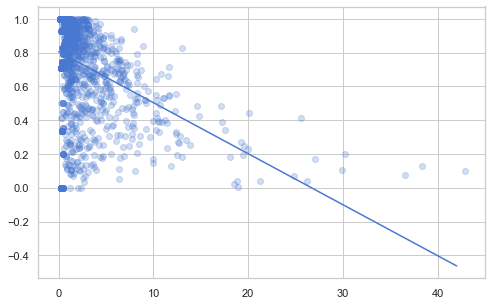

In [223]:
fig, ax = plt.subplots(figsize=(8,5))

all_t, all_sin = [], []
for k, ex in C_metrics.items():
    all_t.extend(ex['path_lengths'])
    all_sin.extend(ex['path_straightness'])

m, b = np.polyfit(all_t, all_sin, 1)
x = np.array([i for i in range(0, round(max(all_t)), 1)])

ax.scatter(all_t, all_sin, color='b', alpha=0.25)
ax.plot(x, m*x + b)

## Clustering Paths by Metrics

In [224]:
# Create dataframe of paths (metrics and coordinate arrays)
from rdp import rdp

path_df = pd.DataFrame(columns=['user_id', 'straightness', 'average_velocity', 'time', 'length',
                                'displacement', 'C_coords', 'L_coords', 'C_coords_rdp', 'gender'])

for k, ex in C_metrics.items():
    user_df = df.loc[k]
    for i, (path_start, path_end) in enumerate(zip(ex['path_breaks'], ex['path_breaks'][1:])):
        row = {}
        row['user_id'] = k
        row['straightness'] = ex['path_straightness'][i]
        row['average_velocity'] = ex['path_velocities'][i]
        row['time'] = ex['path_times'][i]
        row['length'] = ex['path_lengths'][i]
        row['displacement'] = ex['path_displacements'][i]
        row['C_coords'] = user_df.iloc[path_start:path_end][['C_x', 'C_z']].to_numpy()
        row['L_coords'] = user_df.iloc[path_start:path_end][['L_x', 'L_y', 'L_z']].to_numpy()
        row['C_coords_rdp'] = rdp(row['C_coords'], 0.0001)
        row['gender'] = user_df.iloc[0]['gender']
        path_df = path_df.append(row, ignore_index=True)

path_df['gender'] = path_df['gender'].astype("category")
path_df['straightness'] = path_df['straightness'].astype("float64")


In [225]:
path_df.head()

,user_id,straightness,average_velocity,time,length,displacement,C_coords,L_coords,C_coords_rdp,gender
0,1,0.333333,0.018638,17.632,0.300000,0.100000,"[[-19.8, -4.2], [-19.9, -4.2], [-19.9, -4.2], ...","[[-15.5, 2.5, -5.1], [-15.5, 2.5, -5.1], [-15....","[[-19.8, -4.2], [-19.9, -4.2]]",m
1,1,1.000000,0.036523,2.472,0.100000,0.100000,"[[-19.9, -4.2], [-19.8, -4.2], [-19.8, -4.2], ...","[[-15.5, 2.2, -3.9], [-15.5, 2.2, -3.9], [-15....","[[-19.9, -4.2], [-19.8, -4.2]]",m
2,1,0.839125,0.827994,1.484,1.124264,0.943398,"[[-19.8, -4.2], [-19.8, -4.1], [-19.8, -4.1], ...","[[-15.5, 2.4, -4.4], [-15.5, 2.4, -4.4], [-15....","[[-19.8, -4.2], [-19.8, -4.1], [-19.7, -4.1], ...",m
3,1,0.775647,0.273450,5.372,1.441421,1.118034,"[[-19.0, -3.7], [-19.0, -3.6], [-19.0, -3.6], ...","[[-9.3, 2.9, -5.7], [-9.3, 2.9, -5.7], [-9.3, ...","[[-19.0, -3.7], [-19.0, -3.6], [-19.0, -3.7], ...",m
4,1,0.824621,0.073756,6.296,0.500000,0.412311,"[[-17.9, -3.9], [-17.8, -3.9], [-17.8, -3.9], ...","[[-9.3, 3.2, -5.4], [-9.3, 3.2, -5.5], [-9.3, ...","[[-17.9, -3.9], [-17.8, -3.9], [-17.8, -4.0], ...",m


5    930
0    443
3    147
2     65
1     24
4     12
Name: cluster, dtype: int64

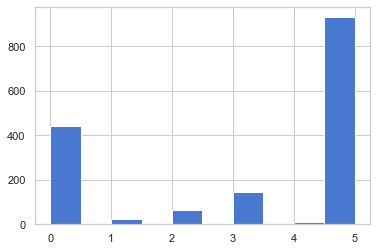

In [226]:
# Cluster paths by metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

n_clusters = 6

clustering = KMeans(n_clusters=n_clusters, n_init=50, max_iter=800, ).fit(path_df[['straightness', 'average_velocity', 'displacement', 'length', 'time']].to_numpy())
# clustering = DBSCAN(eps=0.4, min_samples=5).fit(path_df[['straightness', 'average_velocity', 'displacement', 'length', 'time']].to_numpy())
path_df['cluster'] = clustering.labels_
path_df['cluster'] = path_df['cluster'].astype("category")
path_df['cluster'].hist()

n_clusters = len(np.unique(clustering.labels_))
path_df['cluster'].value_counts()

### Frechet Path Distances and DBSCAN Clustering

Not as effective at discerning different path types (i.e. short sinuous ones vs long wandering)

In [227]:
# from tqdm import tqdm
# import multiprocessing as mp

## Cluster by path similarity measures (frechet)
# import similaritymeasures

# n = len(path_df)

# pbar = tqdm(total=n)

# def dist_row(i):
#     r = np.zeros(n)
#     for j in range(i + 1, n):
#         r[j] = similaritymeasures.frechet_dist(
#             path_df.iloc[i]['C_coords_rdp'], path_df.iloc[j]['C_coords_rdp'])
#     pbar.update(1)
#     return r


# pool = mp.Pool(4)
# results = pool.map(dist_row, range(n))
# results = np.array(results)
# np.save('frechet_matrix.npy', results)
# for i in range(n):
#     for j in range(i+1, n):
#         results[j, i] = results[i, j]

# clustering = DBSCAN(eps=0.5, min_samples=5, metric='precomputed')
# clustering.fit(results)
# path_df['cluster'] = clustering.labels_ + 1

# path_df['cluster'].hist()

# n_clusters = len(np.unique(clustering.labels_))
# path_df['cluster'].value_counts()


### Visualizing path clusters

There are distinct types, the short high straightness movements, and longer wandering paths which curve around the room. The clustering has further broken these types by the metrics (most noticeably time) which can be seen in the violin plots below.

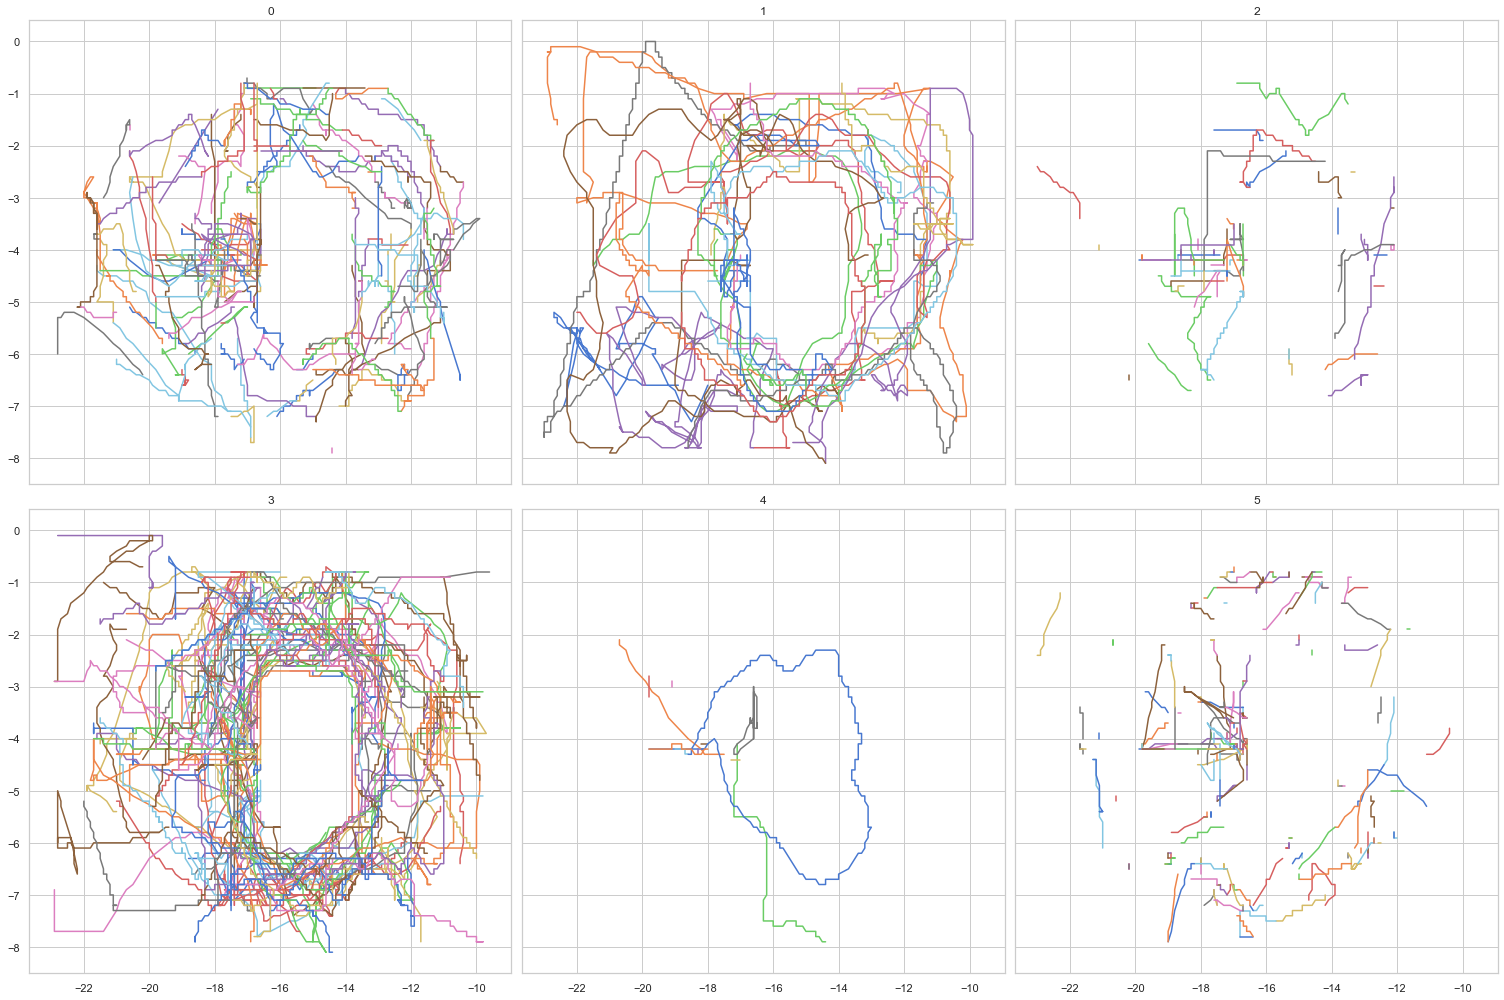

In [228]:
fig, ax = plt.subplots(2, 3, figsize=(21, 14), sharey=True, sharex=True)

for i in range(n_clusters):
    # Plot only 100 from each cluster to reduce noise
    for line in path_df[path_df['cluster'] == i]['C_coords_rdp'].to_list()[:200]:
        ax[i//ax.shape[1], i % ax.shape[1]].plot(line[:, 0], line[:, 1])
    ax[i//ax.shape[1], i % ax.shape[1]].set_title(i)
fig.tight_layout()

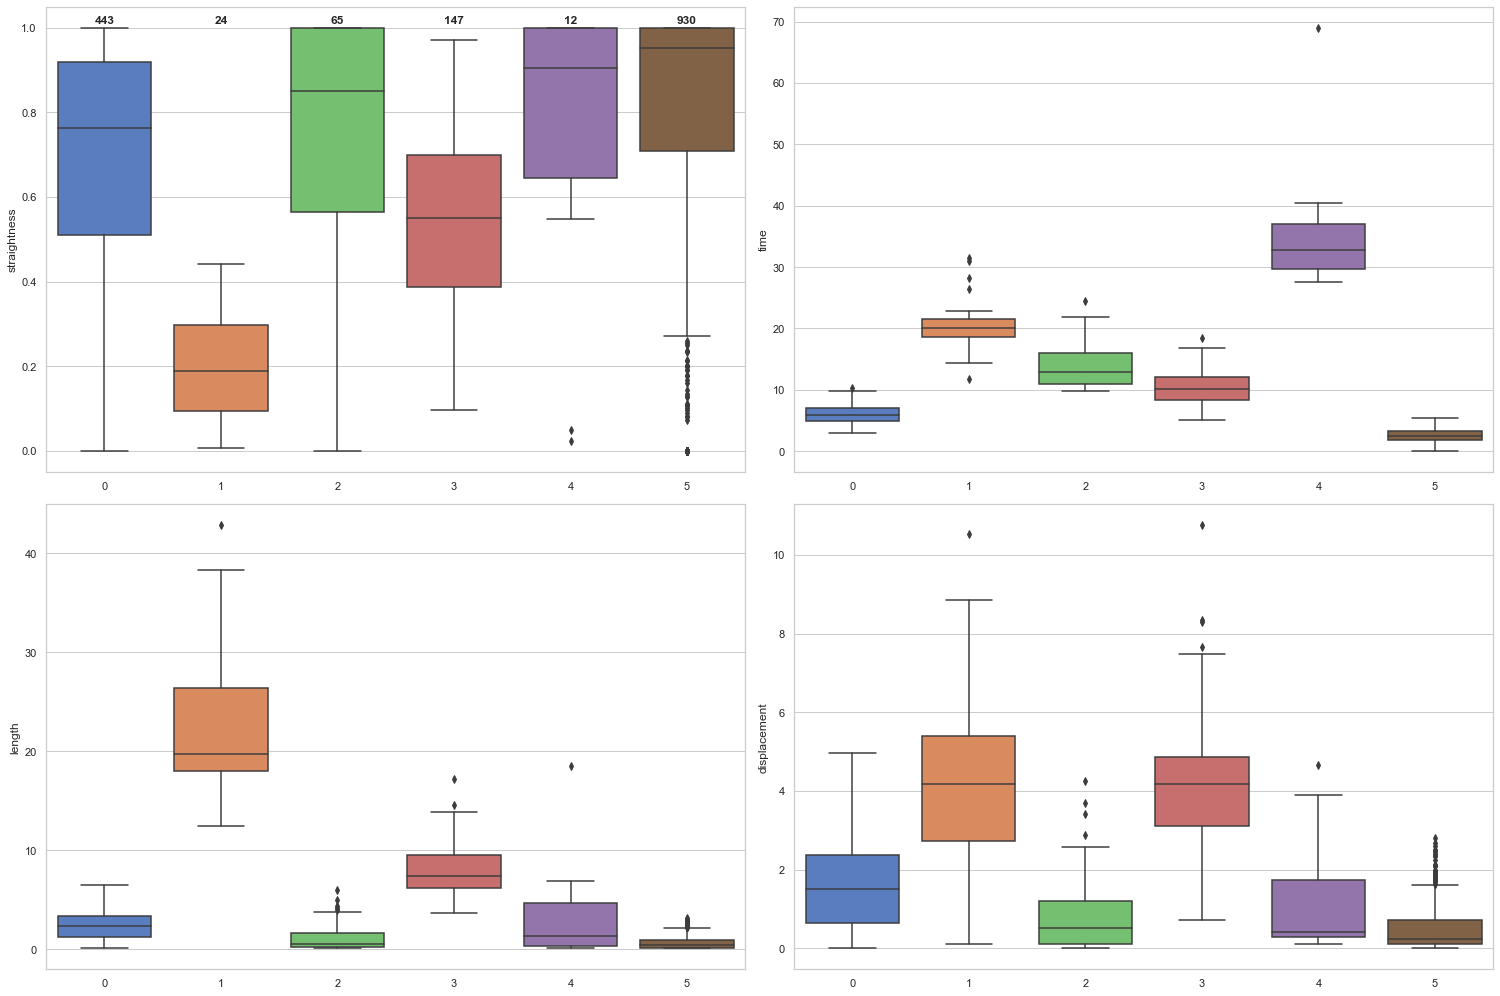

In [229]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(21, 14))
sns.set_theme(style="whitegrid", palette="muted")

nobs = [str(len(path_df[path_df['cluster'] == x])) for x in range(n_clusters)]

sns.boxplot(data=path_df, x="cluster", y="straightness", ax=ax[0, 0])

pos = range(len(nobs))
for tick,label in zip(pos,ax[0, 0].get_xticklabels()):
    ax[0, 0].text(pos[tick], 1.01, nobs[tick], horizontalalignment='center', weight='bold')
ax[0, 0].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="time", ax=ax[0, 1])
ax[0, 1].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="length", ax=ax[1, 0])
ax[1, 0].set_xlabel('')

sns.boxplot(data=path_df, x="cluster", y="displacement", ax=ax[1, 1])
ax[1, 1].set_xlabel('')

fig.tight_layout()

<AxesSubplot:xlabel='straightness', ylabel='time'>

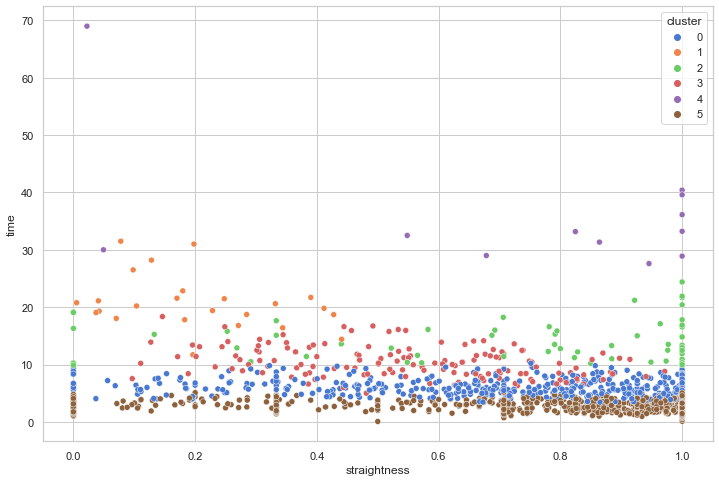

In [230]:
fig, ax = plt.subplots(figsize=(12,8))

sns.scatterplot(data=path_df, x='straightness', y='time', hue='cluster')

## Gender Analysis of Movement Data

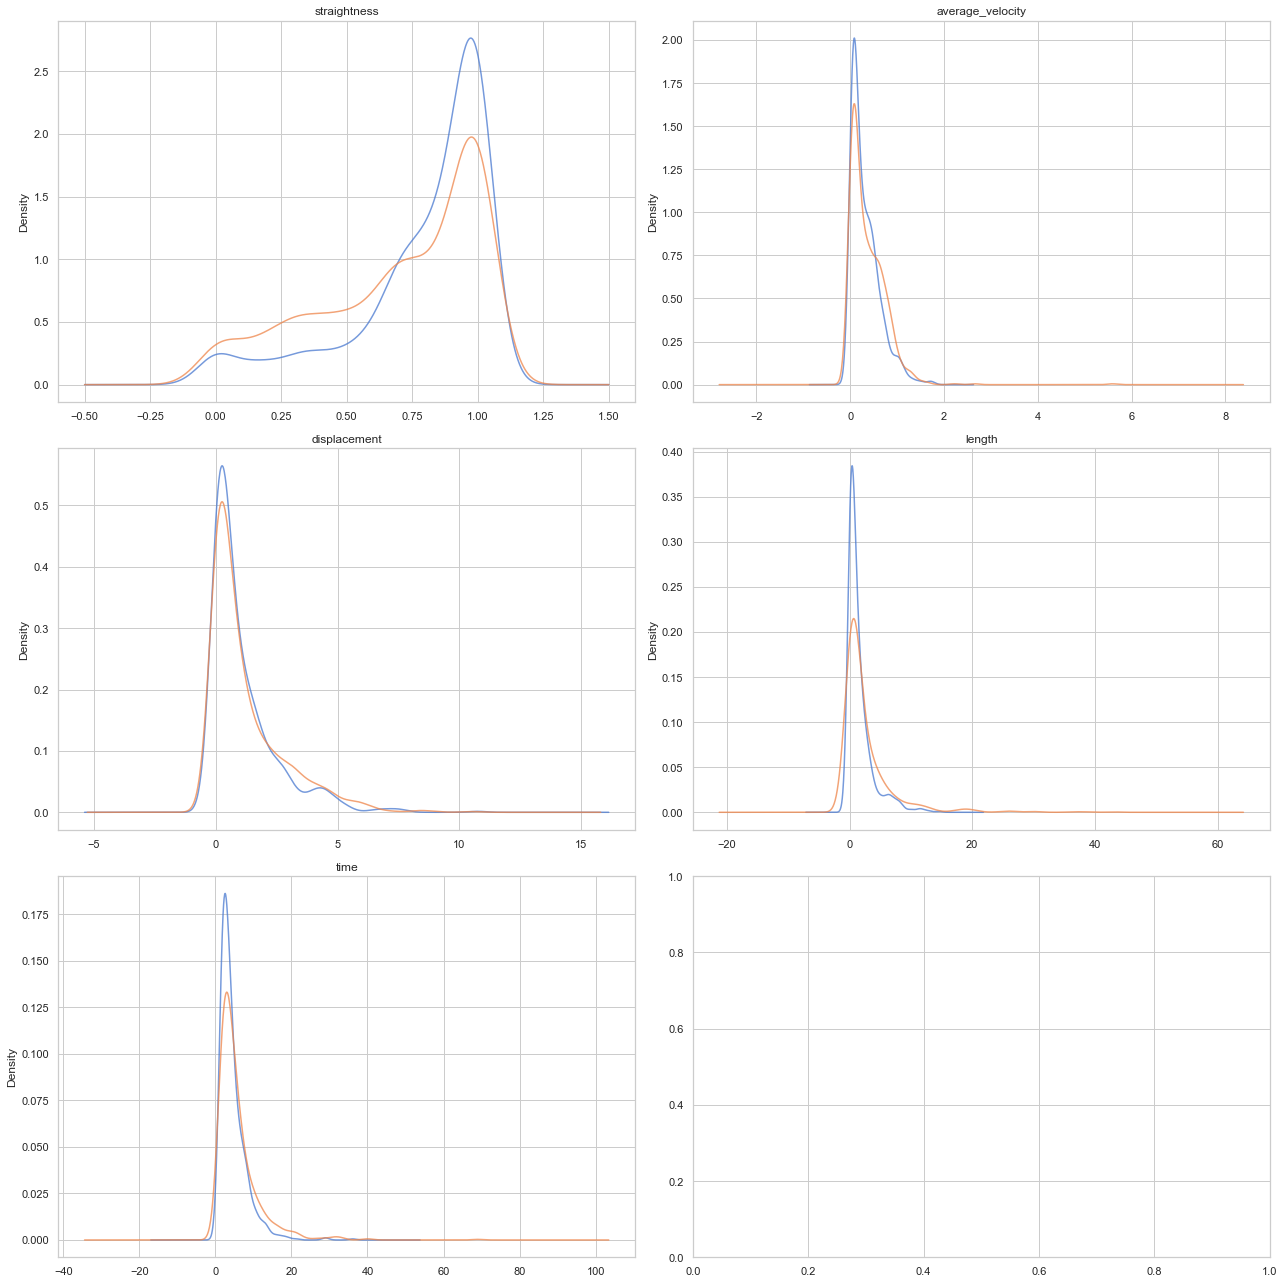

In [231]:
fig, ax = plt.subplots(3, 2, figsize=(18, 18))

for i, cat in enumerate(['straightness', 'average_velocity', 'displacement', 'length', 'time']):
    path_df.groupby('gender')[cat].plot.kde(alpha=0.75, ax=ax[i//ax.shape[1], i % ax.shape[1]])
    ax[i//ax.shape[1], i % ax.shape[1]].set_title(cat)

fig.tight_layout()

There is no discernable difference between the path movement patterns between genders. The descriptive statistics for the path segments by gender are nearly identical in all cases. 

Edit: from what I'm seeing the blue case has much sharper peaks across all variables

# Fixation Identification
Here we implement the I-DT algorithm outlined in Salvucci & Goldberg "Identifying Fixations and Saccades in Eye-Tracking Protocols", as it is suspected this is the algorithm used in the Sitzmann et al

In [316]:
min_fix_time = 0.15 # 150 milliseconds
max_dispersion = 0.01

def calculate_dispersion(window):
    min_x = np.min(window[:,1])
    max_x = np.max(window[:,1])
    min_y = np.min(window[:,2])
    max_y = np.max(window[:,2])
    min_z = np.min(window[:,3])
    max_z = np.max(window[:,3])
    return (max_x - min_x) + (max_y - min_y) + (max_z - min_z)

def calculate_duration(window):
    if window.shape[0] > 0:
        return window[-1,0] - window[0,0]
    else:
        return 0

def identify_fixations(user_df):
    user_fix_df = pd.DataFrame(columns=["start_time", "duration", "centre_x", "centre_y", "centre_z"])
    points_df = user_df[["time", "L_x", "L_y", "L_z"]]
    window = np.empty((0,4))
    next_point_index = 0
    # While there are any points left
    while next_point_index < points_df.shape[0] or window.shape[0] > 0:
        # Initialise the window to cover minimum fixation duration
        while calculate_duration(window) < min_fix_time and next_point_index < points_df.shape[0]:
            window = np.append(window, [points_df.iloc[next_point_index].to_numpy()], axis=0)
            next_point_index += 1

        # If the fixation is not too big
        if calculate_dispersion(window) <= max_dispersion:
            # Add more points until it cannot be bigger
            while calculate_dispersion(window) < max_dispersion and next_point_index < points_df.shape[0]:
                window = np.append(window, [points_df.iloc[next_point_index].to_numpy()], axis=0)
                next_point_index += 1
            # Remove the most recent point if it is too large
            if calculate_dispersion(window) > max_dispersion:
                window = window[:-1,:]
                next_point_index -= 1

            # Record fixation in its final form
            centre_x = np.mean(window[:,1])
            centre_y = np.mean(window[:,2])
            centre_z = np.mean(window[:,3])
            duration = calculate_duration(window)
            user_fix_df.loc[len(user_fix_df.index)] = [window[0,0], duration, centre_x,  centre_y, centre_z]

            # Reset window
            window = np.empty((0,4))
        else:
            # Remove first point from window
            window = window[1:,:]
    return user_fix_df 

In [317]:
fix_df = pd.DataFrame(columns=["id", "index", "start_time", "duration", "centre_x", "centre_y", "centre_z"])
for id in df.reset_index().id.unique():
    user_fix_df = identify_fixations(df.loc[id])
    user_fix_df.loc[:,"id"] = id
    user_fix_df.loc[:,"index"] = user_fix_df.index
    fix_df = fix_df.append(user_fix_df)
fix_df.set_index(["id","index"])

start_time  duration  centre_x  centre_y  centre_z
id index                                                    
1  0           0.068     1.416     -15.5       2.5      -5.1
   1           1.516     1.024     -12.2       3.5      -3.6
   2           2.640     0.724     -12.3       3.5      -3.6
   3           3.396     0.724      -9.3       3.4      -2.8
   4           4.288     0.264      -9.3       3.0      -3.3
...              ...       ...       ...       ...       ...
9  174       120.510     0.200      -9.3       2.1      -3.5
   175       120.740     0.230      -9.3       2.1      -3.7
   176       121.000     0.400      -9.3       2.2      -3.4
   177       121.430     0.260      -9.3       2.0      -3.5
   178       121.720     0.140      -9.3       1.7      -3.7

[8577 rows x 5 columns]

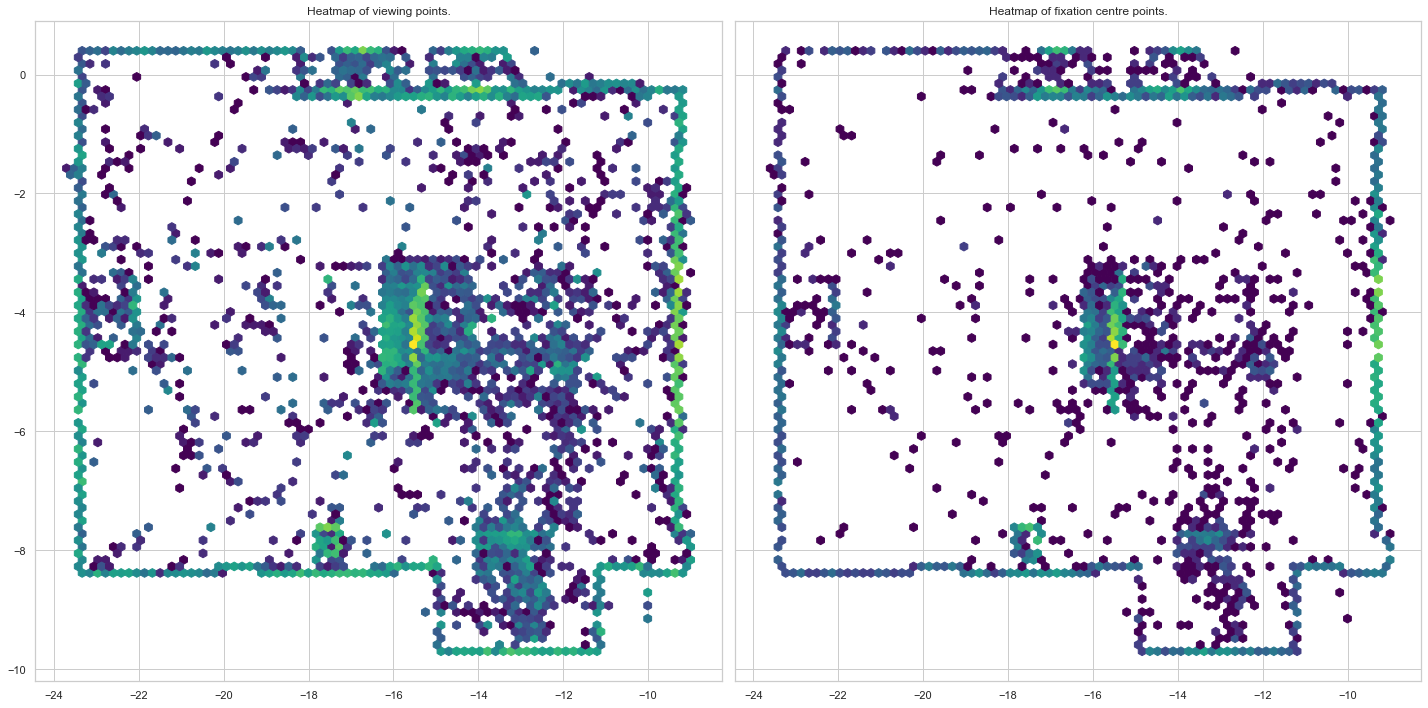

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)
pc = ax[0].hexbin(df['L_x'], df['L_z'], cmap='viridis', mincnt=1, gridsize=80, bins='log')
pc = ax[1].hexbin(fix_df['centre_x'], fix_df['centre_z'], cmap='viridis', mincnt=1, gridsize=80, bins='log')
ax[0].set_title("Heatmap of viewing points.")
ax[1].set_title("Heatmap of fixation centre points.")
fig.tight_layout()

array([[<AxesSubplot:title={'center':'centre_y'}>]], dtype=object)

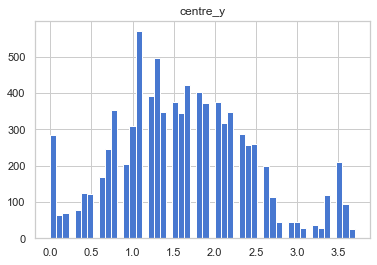

In [328]:
fix_df.hist("centre_y", bins=40)

# POG Movement Analysis

In [249]:
gaze_metrics = {}
long_gaze_velocities = []
long_head_velocities = []

for id in df.reset_index().id.unique():
  user_df = df.loc[id]
  pt = user_df.iloc[0, 0]
  p_phi, p_f_z = user_df.iloc[0][["phi","F_z"]] * 180 / np.pi

  times = []
  user_long_gaze_velocities = [] # 'long_' is short for longitudinal, i.e., the user looking left and right
  user_long_head_velocities = []

  for j in range(1, len(user_df.iloc[1:]) + 1):
    t = user_df.iloc[j, 0]
    phi, f_z = user_df.iloc[j][["phi","F_z"]] * 180 / np.pi

    times.append(t)
    long_gaze_vel = (phi-p_phi)/(t-pt)
    long_head_vel = (f_z-p_f_z)/(t-pt)

    user_long_gaze_velocities.append(long_gaze_vel)
    user_long_head_velocities.append(long_head_vel)
    long_gaze_velocities.append(long_gaze_vel)
    long_head_velocities.append(long_head_vel)

    p_phi, p_f_z, pt = phi, f_z, t

  gaze_metrics[id] = { 't': times, 'long_gaze_vel': user_long_gaze_velocities, 'long_head_vel': user_long_head_velocities}

Text(0, 0.5, 'Longitudinal gaze velocity in $\\frac{degree}{s}$')

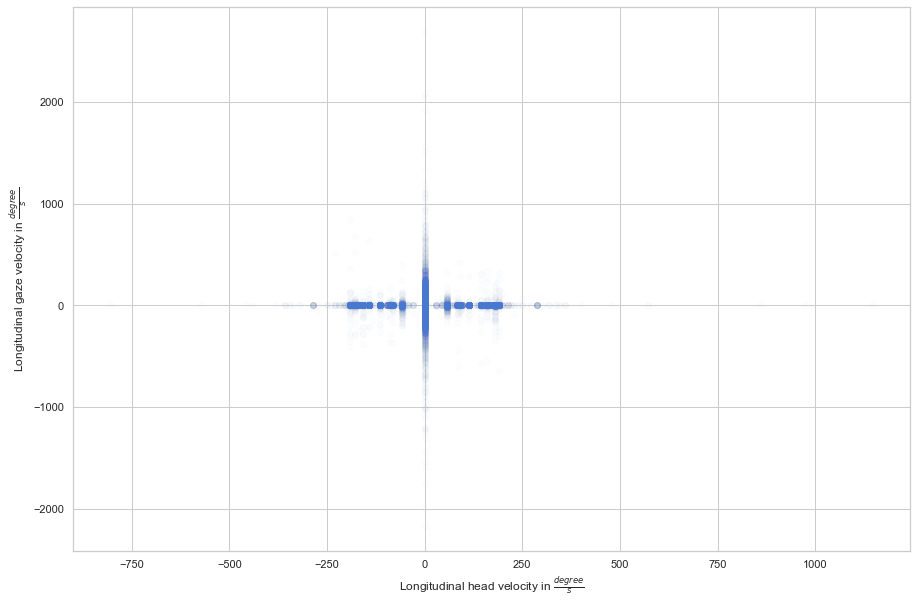

In [250]:
# Fit a line to the fixation data - we should see the vestibulo-ocular reflex!
slope, intercept, r, p, _ = stats.linregress(long_head_velocities, long_gaze_velocities)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(long_head_velocities, long_gaze_velocities, alpha = 0.01, facecolor=None)
#ax.plot(long_head_velocities*slope + intercept, long_head_velocities)
#ax.text(100, 0.007, "Slope %0.2f\nIntercept %0.2f"%(slope, intercept), horizontalalignment='left')

ax.set_xlabel(r'Longitudinal head velocity in $\frac{degree}{s}$')
ax.set_ylabel(r'Longitudinal gaze velocity in $\frac{degree}{s}$')

#ax.set_xlim([-400,400])

In [232]:
# Do users tend to walk towards where they are looking

# average cos(orientation of movement - orientation of eye direction)

